# Neural Networks for Data Science Applications (2019/2020)

## Final exam
**Student(s)**: Cervelli Riccardo (1609772), Farid Rasulov (1870543), Melis Kaymaz (1856307)

**Reference paper / topic**: James Bradbury∗, Stephen Merity∗, Caiming Xiong & Richard Socher. "Quasy-Recurrent Neural Networks."
 Salesforce Research,Palo Alto, California

---



# **Introduction**


The aim of this project was implementing a state-of-the-art architecture from a given scientific paper (see[1]).
In this project we faced the so called Quasi-Recurrent Neural Networks (QRNNs),which face the limits of both Convolutional and Recurrent Neural Networks and try to solve it.
There are mainly two different ways to process the data in deep learning:

1.   Process them all at once in parallel   (images)
2.   Process them word-by-word              (text data)


With the first one, more often applied to images, the same kind of computation happenfor every part of the image simultaneously.
The second, used for text data,means process them from the beginning to the end, taking context into account. What the has been shown in this paper is this is not always true and this is possible mixing point 1 and 2 together, both the behaviour of CNNs and RNNs together in a sort of new kind of Neural Networks called Quasi-Recurrent in which is possible to process  all the text data at once like happens for the images (what CNN actually does), then quickly take into account context and fix then the wrong parts.The goal of the paper was to show how fast QRNNs are compared to LSTMs (which are limited in their capabilty to handle tasks involving long sequences).
At the end what has been shown was that this is true because LSTM allow every neuron's activation for one word in a sentence to depend on every other neuron's activation for the previous word and in QRNNs instead each neuron's activation doesn't depend at all on the past history of any other neurons speeding up the process.






# **MODEL**


QRNNs are build using simple components: a convolution layer and a pooling layer. The basic idea is to use a convolutional layer to compute intermediate representations, then use pooling to handle sequential dependencies. This is expressed conceptually in the diagram below. A block of red means convolution or matrix multiplications and a continuos block of them means that they can be processed in parralel (which means faster).Blue signifies fast, simple functions (parameterless). 

![Figure](https://blog.einstein.ai/content/images/2019/08/qrnn_block.png)

The computation proceeds as follows:

**Step 1: Apply convolutions to compute intermediate vectors and gating vectors**



QRNNs use a regular convolution layer1 in the timestep dimension to compute three vectors for each input: a candidate vector, a forget gate, and an output gate. More specifically, given an input sequence of n-dimensional vectors $x_1,x_2…,x_T$ , the convolution layer for the candidate vectors with $m$ filters produces a sequence of $T$ m-dimensional output vectors $z_1,z_2…,z_T$ . The same goes for the forget gates and output gates. The precise equations are:

$z_t = tanh(conv_{W_z}(x_1,\dots,x_{t-k+1})$

$f_t = \sigma(conv_{W_f}(x_1,\dots,x_{t-k+1})$

$o_t = \sigma(conv_{W_o}(x_1,\dots,x_{t-k+1})$

where $conv$ represents convolution and $k$ is the filter size.

**Step 2: Pool using gating**

Using the inputs computed above, the QRNN computes the hidden states (outputs) according to the following equation:

$c_t = f_t \odot c_{t-1} + (1 - f_t) \odot z_t$

$h_t = o_t \odot c_t$

where $\odot$ represents element-wise multiplication.

This equation looks like the equation for the LSTM, and the difference may seem a bit unclear at first. The important difference is that the sequential processing only occurs in the pooling layer and that the values of $z_t , f_t ,$ and $o_t$ do not depend on any previous values. This is the essence of QRNNs: do the heavy computation in parallel and do minimal sequential processing in the pooling layers.

**VARIANTS**

**Regularization:** The authors propose to apply zoneout to regularize QRNNs. This is equivalent to setting some of the forget gates to 1 at random.

**Densely-Connected Layers:** When stacking QRNNs, the authors also proposed adding skip-connections between all QRNN layers.

In [0]:
import os
import os.path
import sys
import json
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader

tf.test.gpu_device_name()
tf.reset_default_graph()

In [0]:
class QRNNLayer:
    def __init__(self, input_size, conv_size, hidden_size, layer_id, pool='fo', zoneout=0.0, num_in_channels=1):
        
        self.input_size = input_size
        self.conv_size = conv_size if conv_size%2==0 else conv_size+1 # size of convolution matrix
        self.hidden_size = hidden_size # number of convolutions
        self.layer_id = layer_id 
        self.pool = pool # pooling function name
        self.zoneout = zoneout # zoneout coefficient
        self.num_in_channels = num_in_channels # number of channels
        init = tf.random_normal_initializer()
        filter_shape = [conv_size, input_size, num_in_channels, hidden_size*(len(pool)+1)]
        
        with tf.variable_scope('QRNN/conv/'+str(layer_id)):
            self.W = tf.get_variable('W', filter_shape, initializer=init, dtype=tf.float32)
            self.b = tf.get_variable('b', [hidden_size*(len(pool)+1)], initializer=init, dtype=tf.float32)

    # zoneout and pooling
    def __call__(self, inputs, train=None):
        gates = self.conv(inputs)
        if self.zoneout and self.zoneout > 0.0:
            F = gates[2]
            F = tf.cond(train, lambda: 1-tf.nn.dropout(F, 1-self.zoneout), lambda: F)
            gates[2] = F
        if self.pool == 'f': return self.f_pool(gates)
        elif self.pool == 'fo': return self.fo_pool(gates)
        elif self.pool == 'ifo': return self.ifo_pool(gates)

    # convolution operation
    def conv(self, inputs):
        # input dims: [batch x seq x state x in]
        # padded_inputs dims: [batch x seq x state x in]
        padded_inputs = tf.pad(inputs, [[0, 0], [self.conv_size - 1, 0], [0, 0], [0, 0]], "CONSTANT")
        conv = tf.nn.conv2d(padded_inputs, self.W, strides=[1, 1, 1, 1],padding='VALID', name='conv'+str(self.layer_id))
        conv += self.b
        # conv dims: [batch x seq x in x num_conv*3]
        gates = tf.split(conv, (len(self.pool)+1), 3)
        # apply nonlinearities, turn into lists by seq
        gates[0] = tf.tanh(gates[0])
        for i in range(1, len(gates)):
            gates[i] = tf.sigmoid(gates[i])
        return gates

    def unstack(self, gates, pooling):
        if pooling == 'f': Z, F = gates
        elif pooling == 'fo': Z, F, O = gates
        elif pooling == 'ifo': Z, F, O, I = gates

        Z = tf.unstack(Z, axis=1)
        F = tf.unstack(F, axis=1)
        if pooling == 'f': return Z,F
        O = tf.unstack(O, axis=1)
        if pooling == 'fo': return Z,F,O
        I = tf.unstack(O, axis=1)
        if pooling == 'ifo': return Z,F,O,I

    # pooling function
    def fo_pool(self, gates):
        Z, F, O = self.unstack(gates,'fo')
        C = [tf.fill(tf.shape(Z[0]), 0.0)] #tf.zeros(tf.shape(Z[0]), tf.float32) #
        H = []
        for i in range(len(Z)):
            c = tf.multiply(F[i], C[-1]) + tf.multiply(1-F[i], Z[i])
            h = tf.multiply(O[i], c)
            C.append(c)
            H.append(h)
        H = tf.stack(H, axis=1)
        return tf.transpose(H, perm=[0, 1, 3, 2]) 

In [0]:
class DenseLayer:
    def __init__(self, input_size, conv_size, hidden_size, layer_ids, num_layers, zoneout=0.0, dropout=0.0):
        self.layers = []
        self.num_layers = num_layers # number of layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.layers = [QRNNLayer(hidden_size, conv_size, hidden_size,layer_ids[i], pool='fo', zoneout=zoneout, num_in_channels=i+1)\
                                                    if i == 0 else  for i in range(num_layers)]

    def __call__(self, inputs, train=None):
        inputs = tf.layers.dense(tf.transpose(inputs, [0, 1, 3, 2]), self.hidden_size)
        inputs = tf.transpose(inputs, [0, 1, 3, 2])
        for layer in self.layers:
            outputs =  layer(inputs, train=train)
            if self.dropout and self.dropout > 0:
                keep_prob = 1 - self.dropout
                outputs = tf.cond(train, lambda: tf.nn.dropout(outputs, keep_prob), lambda: outputs)
            inputs = tf.concat([inputs, outputs], 3) # connect the layers
        return tf.squeeze(outputs[:, :, :, -1])

In [0]:
class Model:
    def __init__(self, embeddings, BATCH_SIZE, SEQ_LEN, train, beta=4e-6):
        self.batch_size = BATCH_SIZE
        self.seq_len = SEQ_LEN
        self.embeddings = embeddings
        self.train = train

        self.inputs = tf.placeholder(tf.int32, [BATCH_SIZE, SEQ_LEN], name="inputs")
        self.masks = tf.placeholder(tf.float32, [BATCH_SIZE, SEQ_LEN], name="mask")
        self.labels = tf.placeholder(tf.int32, [BATCH_SIZE], name="labels")
        self.train = tf.placeholder(tf.bool, [], name='train')

        x, weights = self.forward()
        loss = self.__call__(x)
        
        self.op = tf.train.RMSPropOptimizer(0.001).minimize(loss)
        self.epoch = tf.Variable(0, dtype=tf.int32, trainable=False, name='epoch')

    def __call__(self, x):
        masks = self.masks
        labels = self.labels
        outputs = tf.reduce_mean(x * tf.expand_dims(masks, -1), 1)
        logits = tf.layers.dense(tf.squeeze(outputs), 2)
        pred = tf.argmax(tf.nn.softmax(logits), -1)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        self.cost = tf.reduce_sum(loss) / self.batch_size
        correct_prediction = tf.equal(tf.cast(pred, tf.int32), labels)
        self.accuracy = tf.reduce_sum(tf.cast(correct_prediction,tf.float32)) / self.batch_size
        
        return loss

In [0]:
class DenseModel(Model):
    def forward(self):
        inputs = self.inputs
        num_layers = 4
        input_size = 300
        num_convs = 256
        conv_size = 2
        x = tf.expand_dims(tf.nn.embedding_lookup(self.embeddings, inputs), -1)
        qrnn = DenseLayer(input_size,conv_size,num_convs,range(num_layers),num_layers, dropout=0.3)
        x = qrnn(x, train=self.train)
        weights = [l.W for l in qrnn.layers] + [l.b for l in qrnn.layers]
        return tf.squeeze(x), weights

In [0]:
def get_embeddings(vocab, path, dim = 300):
    vocab_dict = {word: int(_id) for _id, word in vocab.items()}
    embed_id = path.split('.')[-2]
    if embed_id+'_imdb.json' not in os.listdir('.'):
        embeds = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                split = line.split()
                word = split[0].encode('utf-8').lower()
                vec = split[1:]
                if word in vocab_dict.keys():
                    embeds[vocab_dict[word]] = list(map(float,vec))
        with open(embed_id+'_imdb.json', 'w') as f:
            f.write(json.dumps(embeds))
    else:
        with open(embed_id+'_imdb.json') as f:
            embeds = {int(_id): word for _id, word in json.loads(f.read()).items()}
    embed_list = []
    for i in range(3):
        var = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[dim]), dtype=tf.float32)
        embed_list.append(var)
    for _id, word in vocab.items():
        if int(_id) in embeds.keys(): embed_list.append(tf.constant(embeds[_id], dtype=tf.float32))
        else: embed_list.append(embed_list[2])
    return tf.stack(embed_list, axis=0)

class imdbDataset(Dataset):
    def __init__(self, dataset, seq_len=100):
        self.x = dataset[0]
        self.pad_inputs(seq_len)
        self.get_masks(seq_len)
        self.y = dataset[1]

    def pad_inputs(self, seq_len):
        new_xs = []
        for x in self.x:
            if len(x) > seq_len: x = x[:seq_len]
            elif len(x) < seq_len: x += [0] * (seq_len - len(x))
            assert len(x) == seq_len
            new_xs.append(x)
        self.x = new_xs

    def get_masks(self, seq_len):
        self.masks = []
        for x in self.x:
            mask = [1.0 * (x_i != 0) for x_i in x]
            assert len(mask) == seq_len
            self.masks.append(mask)
 
    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.masks[i], self.y[i]

def get_datasets(batch_size=100, num_words=1000, seq_len=100):
    train, test = imdb.load_data(num_words=num_words)
    vocab = imdb.get_word_index()
    vocab = {int(_id): word.encode('utf-8').lower() for word, _id in vocab.items() if _id <= num_words}
    train = imdbDataset(train, seq_len=seq_len)
    n = int(len(test[0])/2)
    val = imdbDataset((test[0][0:n], test[1][0:n]), seq_len=seq_len)
    test = imdbDataset((test[0][n:], test[1][n:]), seq_len=seq_len)
    if os.path.isfile('./glove.6B.300d.txt')==False:
            !wget http://nlp.stanford.edu/data/glove.6B.zip
            !unzip glove*.zip
    return (DataLoader(train, batch_size), DataLoader(val, batch_size), DataLoader(test, batch_size), vocab)

In [0]:
def run(model, sess, dataset, train=False):
    mean_accuracy = 0.0
    mean_loss = 0.0
    for x, masks, y in dataset:
        input_feed = {
            model.inputs: np.array([i.numpy() for i in x]).T,
            model.masks: np.array([i.numpy() for i in masks]).T,
            model.labels: np.array([i.numpy() for i in y]).T,
            model.train: train
        }

        if train:
            output_feed = [model.cost, model.accuracy, model.op]
            loss, accuracy, _ = sess.run(output_feed, input_feed)
        else:
            output_feed = [model.cost, model.accuracy]
            loss, accuracy = sess.run(output_feed, input_feed)
        mean_loss += loss
        mean_accuracy += accuracy

    mean_loss /= len(dataset)
    mean_accuracy /= len(dataset)
    return mean_loss, mean_accuracy

In [0]:
tf.reset_default_graph()
NUM_EPOCHS = 20
BATCH_SIZE = 25
SEQ_LEN = 400
VOCAB_SIZE = 68379

trainset, valset, testset, vocab = get_datasets(BATCH_SIZE,VOCAB_SIZE,SEQ_LEN)
embeddings = get_embeddings(vocab, './glove.6B.300d.txt')
model = DenseModel(embeddings, BATCH_SIZE, SEQ_LEN, VOCAB_SIZE)
saver = tf.train.Saver()

1646592/1641221 [==============================] - 1s 0us/step
--2020-04-28 14:37:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-28 14:37:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-28 14:37:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182

In [0]:
def plot_performance(train, val, label):
    plt.plot(train)
    plt.plot(val)
    plt.ylabel(label)
    plt.xlabel('epoch')
    if label=='acc':
      plt.legend(['train', 'val'], loc='lower right')
    elif label=='loss':
      plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()

In [0]:
trainloss = []
trainacc = []
valloss = []
valacc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = model.epoch.eval()
    for i in range(epoch, NUM_EPOCHS):
        train_loss, train_acc = run(model, sess, trainset, train=True)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_loss, val_acc = run(model, sess, valset)
        vl_acc.append(val_acc)
        vl_loss.append(val_loss)
        print('epoch: ', i, 'train loss: ', train_loss, 'train acc: ', train_acc, 'val loss: ', val_loss, 'val acc: ', val_acc)
        sess.run(tf.assign(model.epoch, i+1))
    saver.save(sess, 'checkpoints',write_state=True)

epoch:  0 train loss:  0.6853148998022079 train acc:  0.5535200007855893 val loss:  0.669365199804306 val acc:  0.6041600015759468
epoch:  1 train loss:  0.6663877372741699 train acc:  0.6034800022244453 val loss:  0.648580476641655 val acc:  0.6288000038266182
epoch:  2 train loss:  0.6474526377916336 train acc:  0.6312000035047531 val loss:  0.6301768251657486 val acc:  0.6481600034832954
epoch:  3 train loss:  0.6331178836524487 train acc:  0.6446400035023689 val loss:  0.617813973724842 val acc:  0.6639200038313866
epoch:  4 train loss:  0.6221512376666068 train acc:  0.6594400045573712 val loss:  0.6039123462438584 val acc:  0.6788000034689903
epoch:  5 train loss:  0.6122854272723198 train acc:  0.6672800043523311 val loss:  0.596874136686325 val acc:  0.6844000028967857
epoch:  6 train loss:  0.5990313408970833 train acc:  0.6795600041747093 val loss:  0.5907793251872062 val acc:  0.6888000029921532
epoch:  7 train loss:  0.5923090471327305 train acc:  0.6894000036418438 val los

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.get_checkpoint_state('').model_checkpoint_path)
    epoch = model.epoch.eval()
    for i in range(epochs, NUM_EPOCHS):
        train_loss, train_acc = run(model, sess, trainset, train=True)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_loss, val_acc = run(model, sess, valset)
        vl_acc.append(val_acc)
        vl_loss.append(val_loss)
        print('epoch: ', i, 'train loss: ', train_loss, 'train acc: ', train_acc, 'val loss: ', val_loss, 'val acc: ', val_acc)
        sess.run(tf.assign(model.epoch, i+1))
    saver.save(sess, 'checkpoints',write_state=True)

INFO:tensorflow:Restoring parameters from checkpoints
epoch:  10 train loss:  0.5767313345074654 train acc:  0.7058800038993358 val loss:  0.5629765822291374 val acc:  0.7163200035691262
epoch:  11 train loss:  0.5697416437864303 train acc:  0.7059200035631656 val loss:  0.5559571363329887 val acc:  0.7183200053572655
epoch:  12 train loss:  0.5654054255783558 train acc:  0.7162400041520596 val loss:  0.5451382400989533 val acc:  0.7276000036001206
epoch:  13 train loss:  0.5559363066852093 train acc:  0.7223200023174285 val loss:  0.5411429395079612 val acc:  0.7292000037431717
epoch:  14 train loss:  0.5544657707214355 train acc:  0.7224400034844876 val loss:  0.5353631137609481 val acc:  0.7361600025892258
epoch:  15 train loss:  0.5498119496405125 train acc:  0.7269200032353401 val loss:  0.5405908778905869 val acc:  0.7319200034737587
epoch:  16 train loss:  0.5436905031502247 train acc:  0.7331600025594235 val loss:  0.5319896857738495 val acc:  0.741440003991127
epoch:  17 train

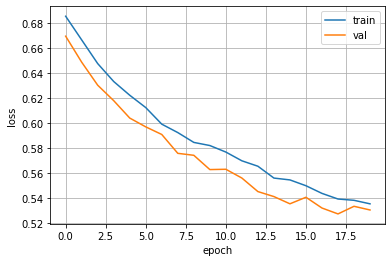

In [6]:
import matplotlib.pyplot as plt
plot_performance(trainloss, valloss, 'loss')

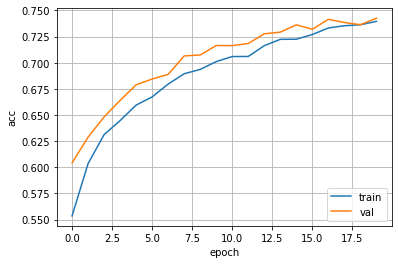

In [9]:
plot_performance(trainacc, valacc, 'acc')

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.get_checkpoint_state('').model_checkpoint_path)
    test_loss, test_acc = run(model, sess, testset)
    print ('test loss: ', test_loss, 'test acc: ', test_acc)

INFO:tensorflow:Restoring parameters from checkpoints
test loss:  0.55588800907135 test acc:  0.7230400323867798
